# Evaluation of the Model

In [1]:
import os
import sys

parent = os.path.dirname(os.path.abspath(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)
    
parent

'c:\\Users\\aless\\Documents\\git\\XAI-Cancer-Diagnosis\\XAI-Cancer-Diagnosis'

# Data and Models

In [2]:
train_ind, val_ind = [], []
src_folder = os.path.join(parent, "data", "processed",
                            "BACH_TRAIN")
graph_split = os.path.join(src_folder, "graph_ind.txt")
with open(graph_split, "r") as f:
    l1 = f.readline().strip()
    l2 = f.readline().strip()
    train_ind = list(map(int, l1[1:-1].split(",")))
    val_ind = list(map(int, l2[1:-1].split(",")))

In [3]:
from src.datasets.BACH import BACH
from torch_geometric.loader.dataloader import DataLoader

train_set, val_set = BACH(src_folder, ids=train_ind,pred_mode=True), BACH(src_folder, ids=val_ind,pred_mode=True)

def get_class(path_name):
    if "Benign" in path_name:
        return 0
    if "InSitu" in path_name:
        return 1
    if "Invasive" in path_name:
        return 2
    return 3

In [4]:
from src.predict_cancer import predict_cancer
import torch
from src.model.architectures.cancer_prediction.pred_gnn import PredGNN
from torch_geometric.transforms import Compose, KNNGraph, RandomTranslate, Distance

gnn_voter_args = {"LAYERS": 12, "WIDTH": 4, "GLOBAL_POOL": "MEAN", "RADIUS_FUNCTION": "INVSQUARE", "POOL_RATIO": 1}
graph_trans = Compose([KNNGraph(6),  Distance(norm=False, cat=False)])

gnn_voter_loc=os.path.join(parent,"model", "GNN_VOTER.ckpt")

def predict(graph):
    with torch.no_grad():
        gnn_voter = PredGNN.load_from_checkpoint(gnn_voter_loc, **gnn_voter_args).eval().cuda()
        voting_graph = graph_trans(graph).cuda()
        prediction = gnn_voter(voting_graph.x, voting_graph.edge_index, voting_graph.edge_attr,
                            torch.zeros(voting_graph.x.shape[0]).long().cuda()).squeeze()
        return prediction

#... run predict_cancer on each image (all 400), and save to a csv along with ground truth.

# ... seperate predictions based on train or val. Create Confusion Matrix

## Confusion Matrix

In [5]:
from src.model.evaluation.confusion_matrix import confusion_matrix
from tqdm import tqdm
def cm(data_set):
    Y,Y_HAT =[],[]
    for graph in tqdm(data_set):
        y = graph.y
        y_hat= predict(graph)
        Y.append(y.item())
        Y_HAT.append(y_hat.argmax().item())
    return confusion_matrix(torch.as_tensor(Y),torch.as_tensor(Y_HAT),num_classes=4)
        
    
tcm = cm(train_set)
vcm = cm(val_set)

100%|██████████| 80/80 [00:11<00:00,  6.91it/s]


In [6]:
def cm_certainty(data_set,threshold=0.6):
    Y,Y_HAT =[],[]
    for graph in tqdm(data_set):
        y = graph.y
        y_hat= predict(graph)
        canc = torch.as_tensor([y_hat[[0,3]].sum(),y_hat[[1,2]].sum()])
        if canc.max()<threshold:
            continue
        Y.append(y.item())
        Y_HAT.append(y_hat.argmax().item())
    return confusion_matrix(torch.as_tensor(Y),torch.as_tensor(Y_HAT),num_classes=4)

100%|██████████| 320/320 [00:48<00:00,  6.66it/s]


<AxesSubplot:>

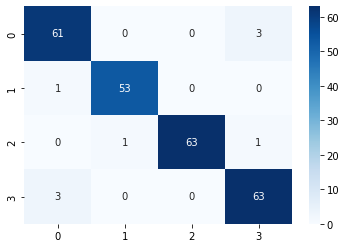

In [12]:
import seaborn as sns
cert_cm = cm_certainty(train_set,0.95)
sns.heatmap(cert_cm, annot=True, fmt=".0f", cmap="Blues")

<AxesSubplot:>

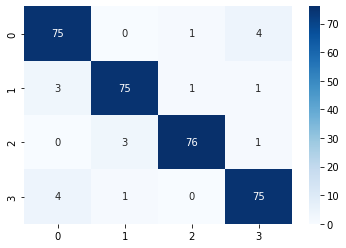

In [8]:


sns.heatmap(tcm, annot=True, fmt=".0f", cmap="Blues")

<AxesSubplot:>

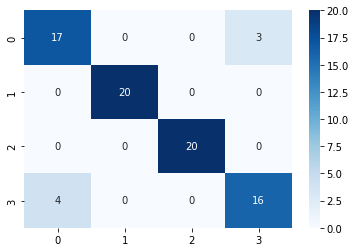

In [9]:
sns.heatmap(vcm, annot=True, fmt=".0f", cmap="Blues")